In [1]:
!pip install -q livelossplot optuna

import os
import zipfile
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import optuna
from optuna.samplers import TPESampler

import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from keras import models, layers
from keras.utils import to_categorical
from keras.initializers import glorot_normal, he_normal
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, ELU, PReLU, LeakyReLU
from keras.optimizers import Adam, RMSprop, Ftrl, Lion
from keras.models import load_model
from livelossplot import PlotLossesKeras

le = LabelEncoder()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.0 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def process_images(filepath):
    """
    Processes a single file, handling both images and ZIP archives.

    Args:
        filepath (str): The path to the file.

    Returns:
        list: A list of processed images (if applicable), empty otherwise.
    """

    processed_images = []
    processed_labels = []
    if zipfile.is_zipfile(filepath):
        with zipfile.ZipFile(filepath, 'r') as z:
            for file in z.namelist():
                if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff')):
                    with z.open(file) as img_file:
                        image = plt.imread(img_file)
                        image = cv2.resize(image, (250, 250), interpolation = cv2.INTER_CUBIC)

                        if filepath == '/content/drive/MyDrive/fotos/arrugados.zip':
                           image = image[50:135, 110:175]
                        elif filepath == '/content/drive/MyDrive/fotos/broca.zip':
                          image = image[50:140, 110:170]
                        elif filepath == '/content/drive/MyDrive/fotos/buenos.zip':
                          image = image[70:160, 80:140]
                        elif filepath == '/content/drive/MyDrive/fotos/decolorado.zip':
                          image = image[35:130, 110:160]
                        elif filepath == '/content/drive/MyDrive/fotos/inmaduro.zip':
                          image = image[80:180, 80:150]
                        elif filepath == '/content/drive/MyDrive/fotos/mordido.zip':
                          image = image[45:140, 120:190]
                        elif filepath == '/content/drive/MyDrive/fotos/negro.zip':
                          image = image[60:150, 80:130]
                        elif filepath == '/content/drive/MyDrive/fotos/vinagre.zip':
                          image = image[50:140, 100:170]

                        image = cv2.resize(image, (224, 224), interpolation = cv2.INTER_CUBIC)
                        processed_images.append(image)
                        processed_labels.append(os.path.splitext(os.path.basename(filepath))[0])
    elif os.path.isfile(filepath):
        if filepath.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff')):
            try:
                image = plt.imread(filepath)
                image = cv2.resize(image, (250, 250), interpolation = cv2.INTER_CUBIC)

                if filepath == '/content/drive/MyDrive/fotos/arrugados.zip':
                    image = image[50:135, 110:175]
                elif filepath == '/content/drive/MyDrive/fotos/broca.zip':
                  image = image[50:140, 110:170]
                elif filepath == '/content/drive/MyDrive/fotos/buenos.zip':
                  image = image[70:160, 80:140]
                elif filepath == '/content/drive/MyDrive/fotos/decolorado.zip':
                  image = image[35:130, 110:160]
                elif filepath == '/content/drive/MyDrive/fotos/inmaduro.zip':
                  image = image[80:180, 80:150]
                elif filepath == '/content/drive/MyDrive/fotos/mordido.zip':
                  image = image[45:140, 120:190]
                elif filepath == '/content/drive/MyDrive/fotos/negro.zip':
                  image = image[60:150, 80:130]
                elif filepath == '/content/drive/MyDrive/fotos/vinagre.zip':
                  image = image[50:140, 100:170]

                image = cv2.resize(image, (224, 224), interpolation = cv2.INTER_CUBIC)
                processed_images.append(image)
                processed_labels.append(os.path.splitext(os.path.basename(filepath))[0])
            except (OSError, IOError):  # Handle potential image opening errors gracefully
                print(f"Error opening image: {filepath}")

    processed_images = processed_images[:64]
    processed_labels = processed_labels[:64]

    return processed_images, processed_labels

def count_images(imgpath):
    """
    Counts images in a directory and its subdirectories.

    Args:
        imgpath (str): The base directory path.

    Returns:
        tuple: A tuple containing (list of directories, list of image counts per directory, total image count).
    """

    directories = []
    total_count = 0
    current_count = []
    images = []
    labels = []

    for root, _, filenames in os.walk(imgpath):
        # print('leyendo imagenes de ', root)
        for filename in filenames:
            # print('leyendo imagenes de ', os.path.join(root, filename))
            processed_images, processed_labels = process_images(os.path.join(root, filename))

            images.extend(processed_images)
            labels.extend(processed_labels)
            directories.append(os.path.join(root, filename))

            current_count.append(len(processed_images))
            total_count = sum(current_count)

    return directories, current_count, total_count, images, labels


In [26]:
def visualize_graphs(test_X, test_Y, predicted_classes, figsize=(20, 40), nrows=11, ncols=5):
  """
  Visualizes multiple graphs in a grid layout, coloring nodes based on labels.

  Args:
      test_X: The input data for the test set.
      test_Y: The true class labels for the test set.
      predicted_classes: The predicted class labels for the test set.
      figsize (tuple, optional): Size of the figure. Defaults to (20, 14).
      nrows (int, optional): Number of rows in the grid layout. Defaults to 7.
      ncols (int, optional): Number of columns in the grid layout. Defaults to 9.
  Returns:
      None
  """

  fig, axs = plt.subplots(nrows, ncols, figsize=figsize)
  axs = axs.flatten()

  for i, e in enumerate(test_Y):
      axs[i].imshow(test_X[e], cmap = 'gray')

      if labels is not None:
        axs[i].set_title(f"Original: {le.inverse_transform(test_Y)[i]} \n Predicción {le.inverse_transform(predicted_classes)[i]}", fontsize=20)

      axs[i].axis("off")

  # Turn off graphics over 62
  for j in range(len(predicted_classes), len(axs)):
      axs[j].axis("off")


  plt.tight_layout()
  plt.show()

In [5]:
# Replace with your actual directory path
imgpath = '/content/drive/MyDrive/fotos'
directories, current_count, total_count, images, labels = count_images(imgpath)

print('Directorios leídos:', len(directories))
print('Imágenes en cada directorio:', current_count)
print('Suma total de imágenes en subdirectorios:', total_count)
print('Número de etiquetas:', len(labels))

Directorios leídos: 8
Imágenes en cada directorio: [64, 64, 64, 64, 64, 64, 64, 64]
Suma total de imágenes en subdirectorios: 512
Número de etiquetas: 512


La imagen corresponde a la categoria: Arrugados


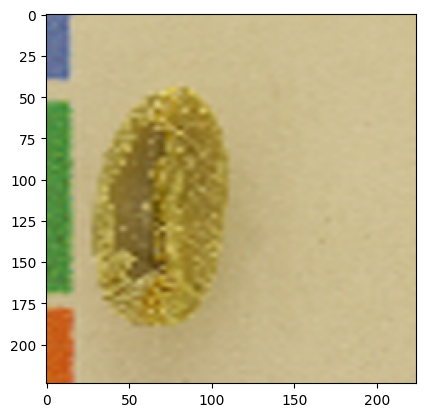

In [6]:
imagen_ver = images[60]
etiqueta_ver = labels[60]
print(f'La imagen corresponde a la categoria: {etiqueta_ver.capitalize()}')
plt.imshow(imagen_ver)
plt.show()

In [7]:
y = le.fit_transform(labels)

# convertir array las images y labels
y = np.array(y)
X = np.array(images)

classes = np.unique(y)
nClasses = len(classes)

print('Clases originales: ', le.classes_)
print('Total de numero de salidas: ', nClasses)
print('Output classes: ', classes)

Clases originales:  ['arrugados' 'broca' 'buenos' 'decolorado' 'inmaduro' 'mordido' 'negro'
 'vinagre']
Total de numero de salidas:  8
Output classes:  [0 1 2 3 4 5 6 7]


In [8]:
# train and test, todas las imagenes tienen la misma dimension
train_X, test_X, train_Y, test_Y = train_test_split(X, y, test_size = 0.1)
print('Training data shape: ', train_X.shape, train_Y.shape)
print('Test data shape: ', test_X.shape, test_Y.shape)

Training data shape:  (460, 224, 224, 3) (460,)
Test data shape:  (52, 224, 224, 3) (52,)


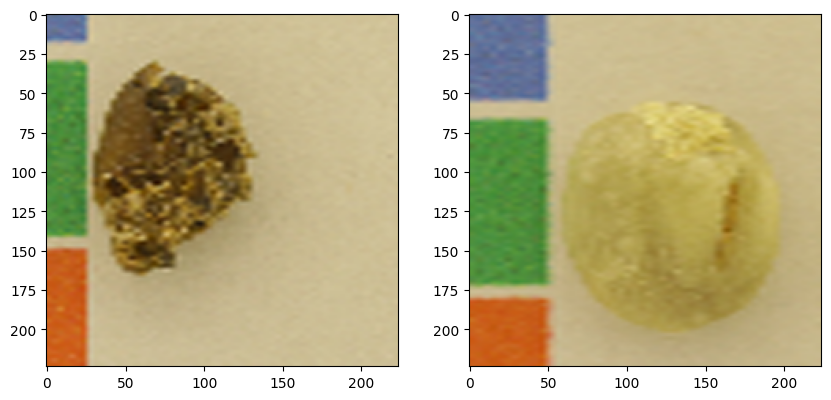

In [9]:
plt.figure(figsize = [10, 8])

# primera imagen de training data
plt.subplot(121)
plt.imshow(train_X[0,:,:], cmap = 'gray')

# primera imagen de testing data
plt.subplot(122)
plt.imshow(test_X[0,:,:], cmap = 'gray');

In [10]:
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')

train_X = train_X / 255.
test_X = test_X / 255.

# cambio a categorico
train_Y_one_hot = to_categorical(train_Y)
test_y_one_hot = to_categorical(test_Y)

In [11]:
train_X, valid_X, train_label, valid_label = train_test_split(train_X, train_Y_one_hot, test_size = 0.2, random_state = 42)
print(train_X.shape, valid_X.shape, train_label.shape, valid_label.shape)

(368, 224, 224, 3) (92, 224, 224, 3) (368, 8) (92, 8)


In [12]:
# taza de aprendizaje
INIT_LR = 0.001
# iteraciones por conjnto de entrenamiento
epochs = 30
# cantidad de imagenes que se toman a la vez en memoria
batch_size = 64

# input_shape = (250, 250, 3)
input_shape = (224, 224, 3)

## Modelo pre-entrenado

In [13]:
# Cargar VGG16 pre-entrenado sin las capas finales (include_top=False)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Congelar las capas pre-entrenadas

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [14]:
# Crear un modelo secuencial con las capas base pre-entrenadas
model_pre = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Aplana las características
    Dense(128, activation='relu'),  # Capa densa personalizada
    Dropout(0.5),  # Regularización
    Dense(nClasses, activation='softmax')  # Capa de salida con 8 clases
])

In [15]:
model_pre.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,781,384 (56.39 MB)

 Trainable params: 66,696 (260.53 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

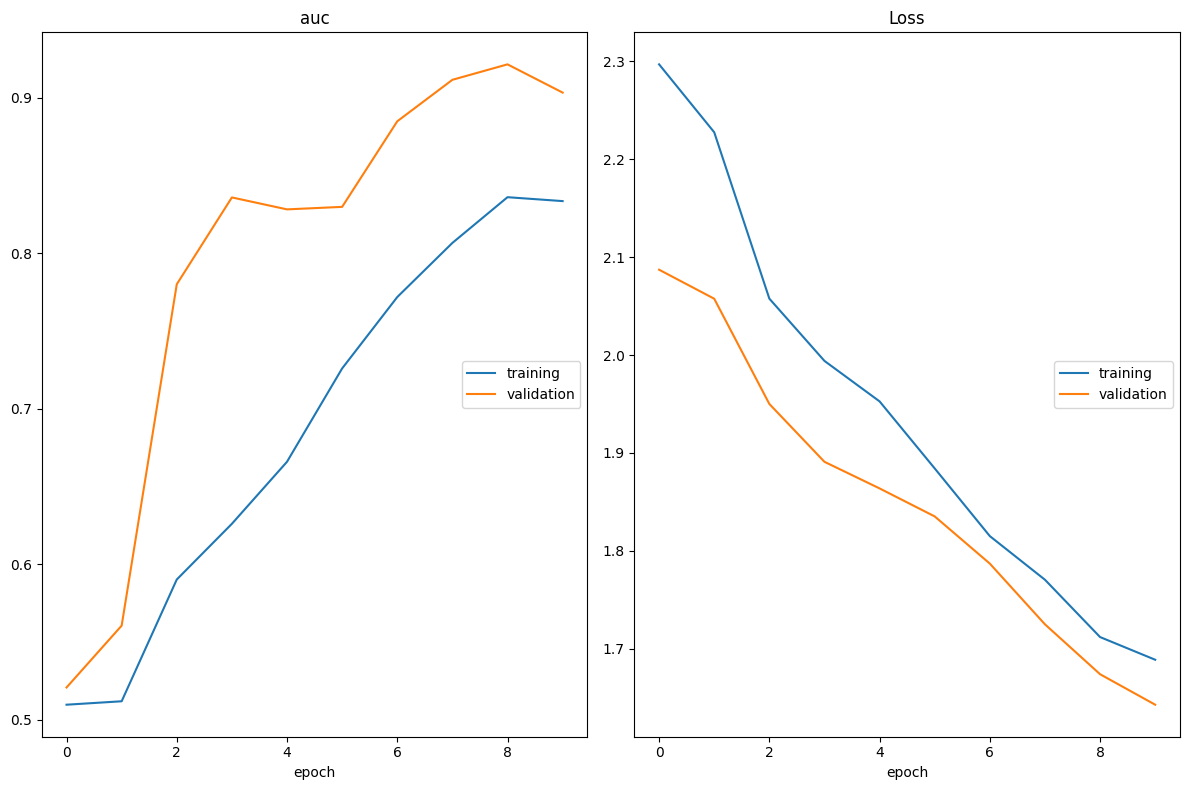

auc
	training         	 (min:    0.510, max:    0.836, cur:    0.834)
	validation       	 (min:    0.521, max:    0.921, cur:    0.903)
Loss
	training         	 (min:    1.689, max:    2.297, cur:    1.689)
	validation       	 (min:    1.643, max:    2.087, cur:    1.643)
6/6 ━━━━━━━━━━━━━━━━━━━━ 320s 51s/step - auc: 0.8229 - loss: 1.7118 - val_auc: 0.9033 - val_loss: 1.6429


In [16]:
model_pre.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['auc'])

# Entrenar el modelo (asumiendo que tienes X_train, y_train y validación)
model_pre.fit(train_X, train_label,
          batch_size = batch_size,
          epochs = 10,
          verbose = 1,
          validation_data = (valid_X, valid_label),
          callbacks=[PlotLossesKeras()])

In [17]:
model_pre.evaluate(test_X, test_y_one_hot, verbose = 1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 30s 12s/step - auc: 0.9192 - loss: 1.5831


[1.5836341381072998, 0.9217296838760376]

In [18]:
# Almacenar modelo
model_pre.save('model_pre_entrenado.h5')

In [19]:
# # Cargar modelo
# model_cargado = load_model('model_pre_entrenado.h5')
# model_cargado.summary()

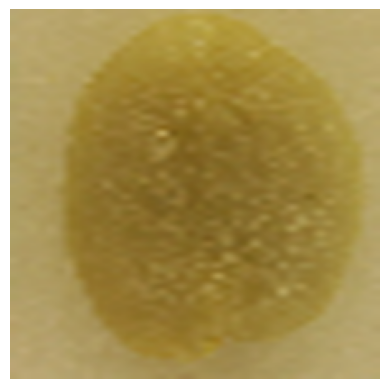

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
La predicción del modelo es: 2 La imagen corresponde a la clase: Buenos


In [20]:
# Preprocesamiento de imagen para hacer prediccion del modelo
image_test = plt.imread('/content/foto_test.JPG')
image_test = cv2.resize(image_test, (250, 250), interpolation = cv2.INTER_CUBIC)
image_test = image_test[70:140, 90:130]
image_test = cv2.resize(image_test, (224, 224), interpolation = cv2.INTER_CUBIC)

plt.imshow(image_test)
plt.axis("off")
plt.show()

image_test = np.array(image_test)
image_test = image_test.astype('float32')
image_test = np.expand_dims(image_test, axis=0)
image_test = image_test / 255.

# Realizar la predicción
predictions = model_pre.predict(image_test, batch_size=None, verbose="auto", steps=None, callbacks=None)
predicted_class_label = le.inverse_transform([np.argmax(predictions)])[0]

# Imprimir la predicción
print(f'La predicción del modelo es: {np.argmax(predictions)} La imagen corresponde a la clase: {predicted_class_label.capitalize()}')

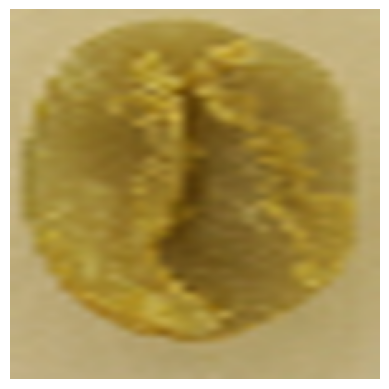

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 822ms/step
La predicción del modelo es: 2 La imagen corresponde a la clase: Buenos


In [21]:
# Preprocesamiento de imagen para hacer prediccion del modelo
image_test = plt.imread('/content/foto_test2.JPG')
image_test = cv2.resize(image_test, (250, 250), interpolation = cv2.INTER_CUBIC)
image_test = image_test[50:110, 120:150]
image_test = cv2.resize(image_test, (224, 224), interpolation = cv2.INTER_CUBIC)

plt.imshow(image_test)
plt.axis("off")
plt.show()

image_test = np.array(image_test)
image_test = image_test.astype('float32')
image_test = np.expand_dims(image_test, axis=0)
image_test = image_test / 255.

# Realizar la predicción
predictions = model_pre.predict(image_test, batch_size=None, verbose="auto", steps=None, callbacks=None)
predicted_class_label = le.inverse_transform([np.argmax(predictions)])[0]

# Imprimir la predicción
print(f'La predicción del modelo es: {np.argmax(predictions)} La imagen corresponde a la clase: {predicted_class_label.capitalize()}')

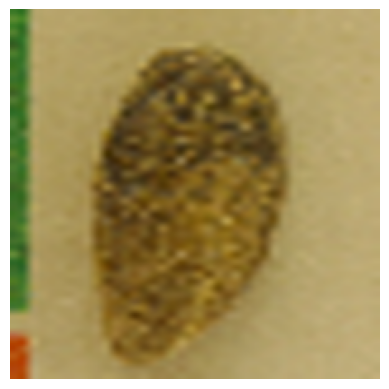

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/step
La predicción del modelo es: 6 La imagen corresponde a la clase: Negro


In [22]:
# Preprocesamiento de imagen para hacer prediccion del modelo
image_test = plt.imread('/content/foto_test3.JPG')
image_test = cv2.resize(image_test, (250, 250), interpolation = cv2.INTER_CUBIC)
image_test = image_test[70:125, 80:120]
image_test = cv2.resize(image_test, (224, 224), interpolation = cv2.INTER_CUBIC)

plt.imshow(image_test)
plt.axis("off")
plt.show()

image_test = np.array(image_test)
image_test = image_test.astype('float32')
image_test = np.expand_dims(image_test, axis=0)
image_test = image_test / 255.

# Realizar la predicción
predictions = model_pre.predict(image_test, batch_size=None, verbose="auto", steps=None, callbacks=None)
predicted_class_label = le.inverse_transform([np.argmax(predictions)])[0]

# Imprimir la predicción
print(f'La predicción del modelo es: {np.argmax(predictions)} La imagen corresponde a la clase: {predicted_class_label.capitalize()}')

## Revision

In [23]:
pred_y = model_pre.predict(test_X)

predicted_classes = []
for predicted_s in pred_y:
    predicted_classes.append(predicted_s.tolist().index(max(predicted_s)))
predicted_classes = np.array(predicted_classes)

2/2 ━━━━━━━━━━━━━━━━━━━━ 29s 10s/step


In [24]:
# verificacion de las predicciones correctas
correct = np.where(predicted_classes == test_Y)[0]
print('Se encontraron {} predicciones correctas'.format(len(correct)))

# verificacion de las predicciones incorrectas
incorrect = np.where(predicted_classes != test_Y)[0]
print('Se encontraron {} predicciones incorrectas'.format(len(incorrect)))

Se encontraron 32 predicciones correctas
Se encontraron 20 predicciones incorrectas


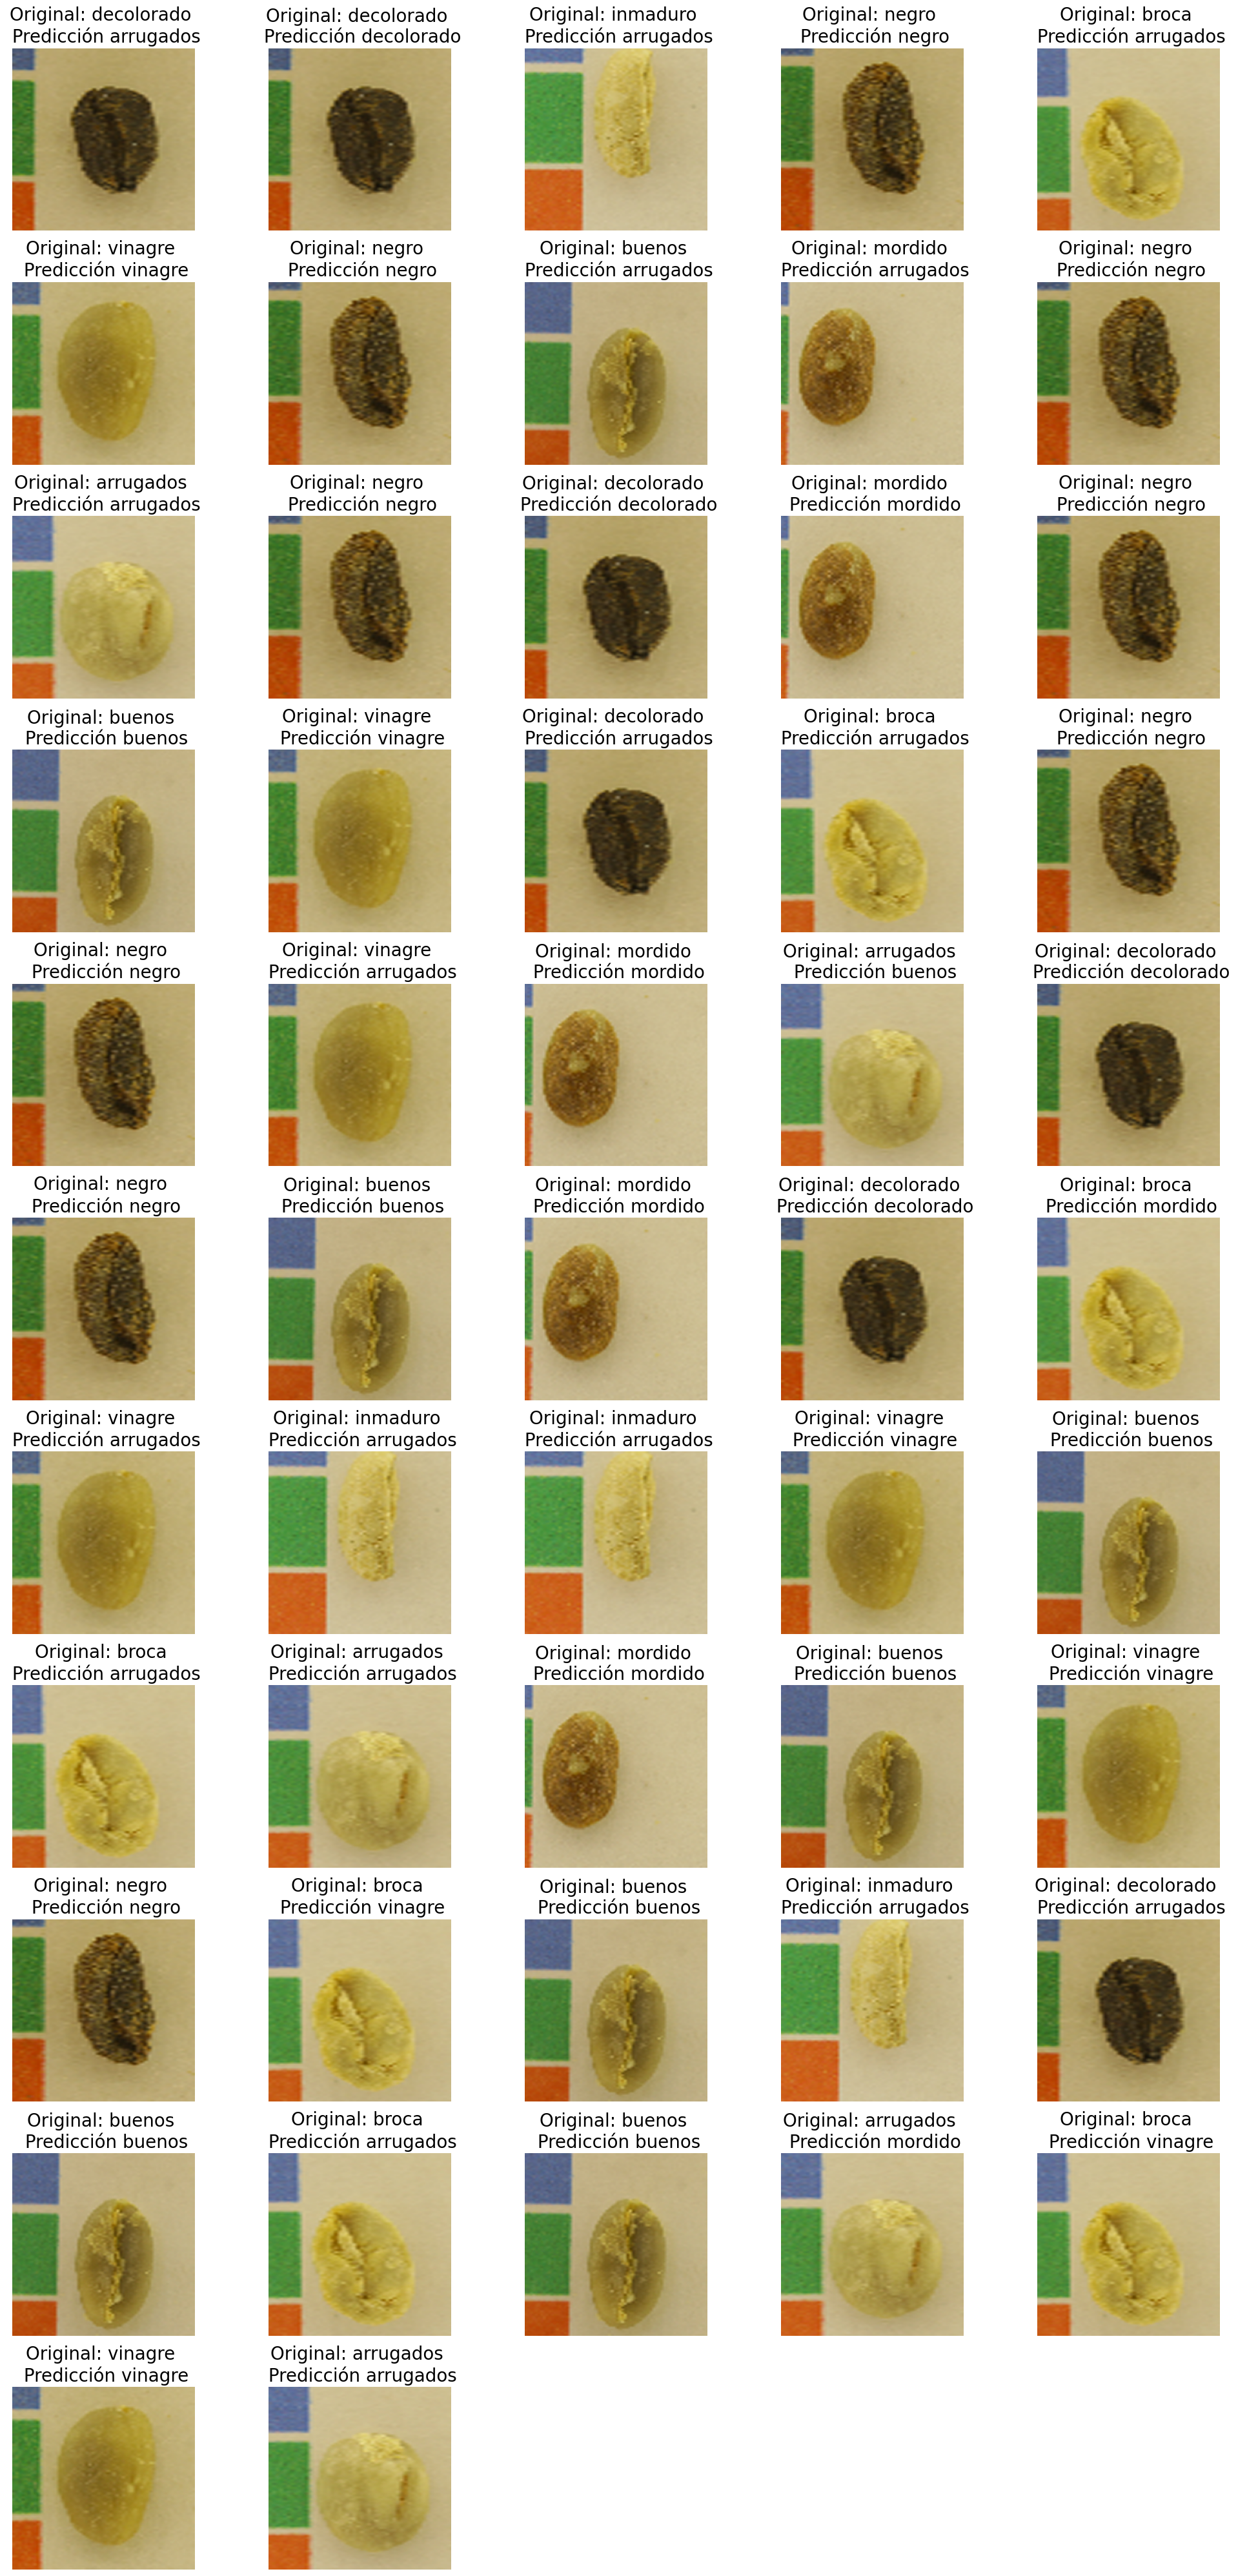

In [27]:
visualize_graphs(test_X, test_Y, predicted_classes)

In [28]:
target_names = ['class {}'.format(i) for i in range(nClasses)]
print(classification_report(test_Y, predicted_classes, target_names = target_names))

              precision    recall  f1-score   support

     class 0       0.17      0.60      0.26         5
     class 1       0.00      0.00      0.00         7
     class 2       0.88      0.88      0.88         8
     class 3       1.00      0.57      0.73         7
     class 4       0.00      0.00      0.00         4
     class 5       0.67      0.80      0.73         5
     class 6       1.00      1.00      1.00         9
     class 7       0.71      0.71      0.71         7

    accuracy                           0.62        52
   macro avg       0.55      0.57      0.54        52
weighted avg       0.62      0.62      0.60        52



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


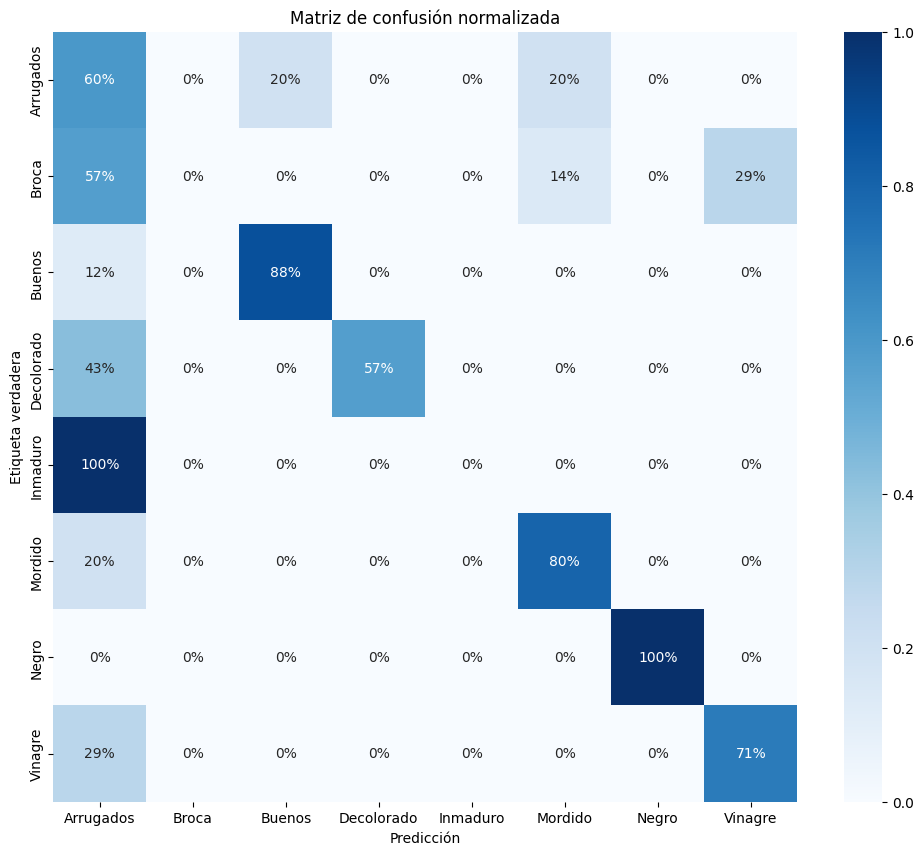

In [29]:
cm = confusion_matrix(test_Y, predicted_classes, normalize='true')
class_labels = ['Arrugados', 'Broca', 'Buenos', 'Decolorado', 'Inmaduro', 'Mordido', 'Negro', 'Vinagre']

fig, axs = plt.subplots(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='.0%', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicción')
plt.ylabel('Etiqueta verdadera')
plt.title('Matriz de confusión normalizada')
plt.show()